In [122]:
import json
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import sklearn.neighbors as nb

import utils

In [123]:
dataset_path = "../datasets/UrbanVehicle"
data_path = "./data"

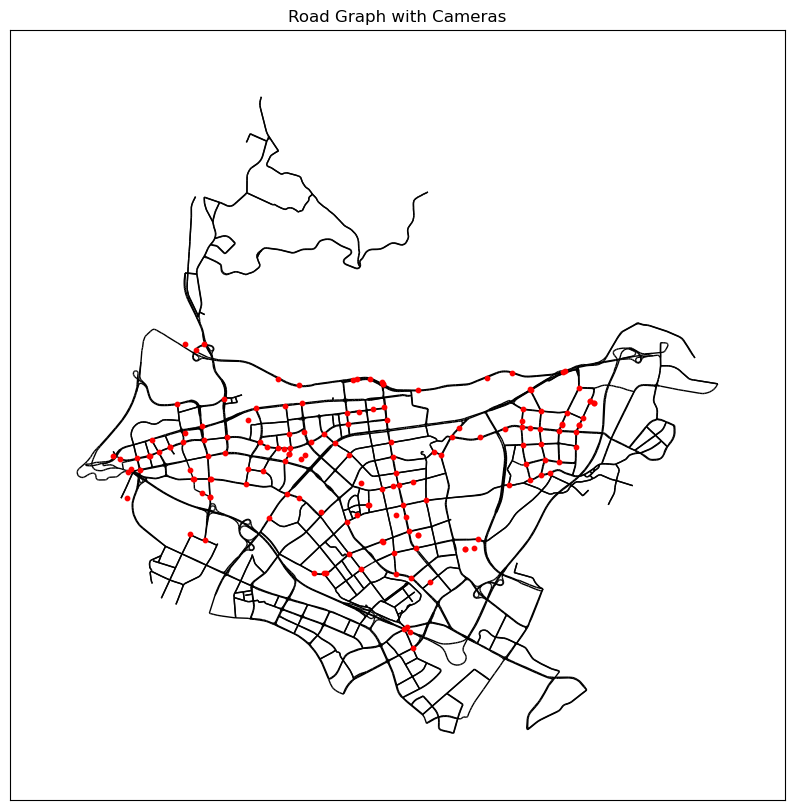

In [124]:
## Load road graph
road_graph: nx.DiGraph
with open(f"{data_path}/road_graph_nsl_sc.pickle", mode="rb") as file:
    road_graph = pickle.load(file)

## Load cameras
cameras = list()
with open(f"{dataset_path}/cameras.json", mode="r", encoding="utf-8") as file:
    for line in file:
        camera = json.loads(line)
        cameras.append({"camera_id": camera["camera_id"], "x": camera["position"][0], "y": camera["position"][1]})

camera_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])

## Draw cameras on road graph
pos = nx.get_node_attributes(road_graph, "pos")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    ax=ax
)
ax.scatter(camera_coordinates[:, 0], camera_coordinates[:, 1], s=10, c="red")
ax.set_title("Road Graph with Cameras")

plt.savefig(f"{data_path}/road_graph_nsl_sc_cam.svg")
plt.show()

In [125]:
## Match cameras to nearest node
nodes = [{"node_id": node, "x": road_graph.nodes[node]["pos"][0], "y": road_graph.nodes[node]["pos"][1]} for node in
         road_graph.nodes()]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

tree = nb.KDTree(node_coordinates)
indices = tree.query(camera_coordinates, k=1, return_distance=False)
indices = indices.flatten()

for index, camera in zip(indices, cameras):
    camera["node_id"] = nodes[index]["node_id"]

In [126]:
## Assign records to cameras
cameras_dict = {camera["camera_id"]: camera for camera in cameras}

with open(f"{dataset_path}/records/records.json", mode="r", encoding="utf-8") as file:
    for line in file:
        record = json.loads(line)
        camera = cameras_dict[record["camera_id"]]
        if "records" in camera:
            camera["records"] += 1
        else:
            camera["records"] = 1

# Camera Info format:
# {
#   camera_id: {
#       "camera_id": int,       Camera ID
#       "x": float,             X coordinate (or Longitude)
#       "y": float,             Y coordinate (or Latitude)
#       "node_id": int,         Nearest node (or OSMID)
#       "records": int          Number of records
#   }
# }

# Save camera info
with open(f"{data_path}/road_graph_cameras.pickle", mode="wb") as file:
    pickle.dump(cameras_dict, file)

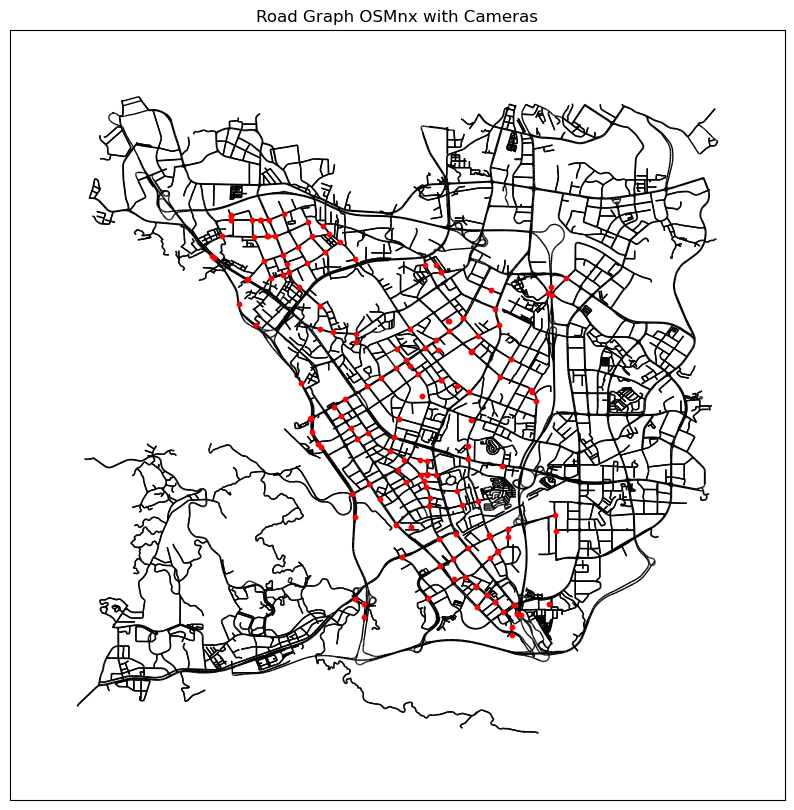

In [127]:
## Load OSMnx road graph
road_graph_ox = ox.load_graphml(filepath=f"{data_path}/road_graph_ox_nsl_sc.xml")
# road_graph_ox = ox.load_graphml(filepath=f"{data_path}/road_graph_ox_sim_nsl_sc.xml")
road_graph_ox = ox.project_graph(road_graph_ox, to_crs=utils.EPSG_32650)

## Project camera coordinates
for camera in cameras:
    x, y = camera["x"], camera["y"]
    proj_gps = utils.xy_to_epsg4326(np.array([[x, y]]))
    proj_gps = utils.epsg4326_to_epsg32650(proj_gps)
    lon, lat = proj_gps[0, 0], proj_gps[0, 1]
    camera["x"] = lon
    camera["y"] = lat

camera_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])

## Draw cameras on road graph
pos = {node: (road_graph_ox.nodes[node]["x"], road_graph_ox.nodes[node]["y"]) for node in road_graph_ox.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx_edges(
    road_graph_ox,
    pos,
    arrows=False,
    ax=ax
)
ax.scatter(camera_coordinates[:, 0], camera_coordinates[:, 1], s=10, c="red")
ax.set_title("Road Graph OSMnx with Cameras")

plt.savefig(f"{data_path}/road_graph_ox_nsl_sc_cam.svg")
# plt.savefig(f"{data_path}/road_graph_ox_sim_nsl_sc_cam.svg")
plt.show()

In [128]:
## Match cameras to nearest node
nodes = [{"node_id": node, "x": road_graph_ox.nodes[node]["x"], "y": road_graph_ox.nodes[node]["y"]} for node in
         road_graph_ox.nodes()]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

tree = nb.KDTree(node_coordinates)
indices = tree.query(camera_coordinates, k=1, return_distance=False)
indices = indices.flatten()

for index, camera in zip(indices, cameras):
    camera["node_id"] = nodes[index]["node_id"]

# Save camera info
with open(f"{data_path}/road_graph_ox_cameras.pickle", mode="wb") as file:
    pickle.dump(cameras_dict, file)

# with open(f"{data_path}/road_graph_ox_sim_cameras.pickle", mode="wb") as file:
#     pickle.dump(cameras_dict, file)